# Object Detection with RefineDet

In [1]:
# encoding: utf-8
import os
import sys
root_path = os.path.abspath(os.path.join('..'))
sys.path.append(root_path)
import _init_paths
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data as data
from PIL import Image
import cv2
from libs.networks.vgg_refinedet import VGGRefineDet
from libs.networks.resnet_refinedet import ResNetRefineDet
from libs.utils.config import voc320, MEANS
from libs.data_layers.transform import base_transform
from matplotlib import pyplot as plt

import pdb

Construct vgg16_refinedet network.
Initializing weights...


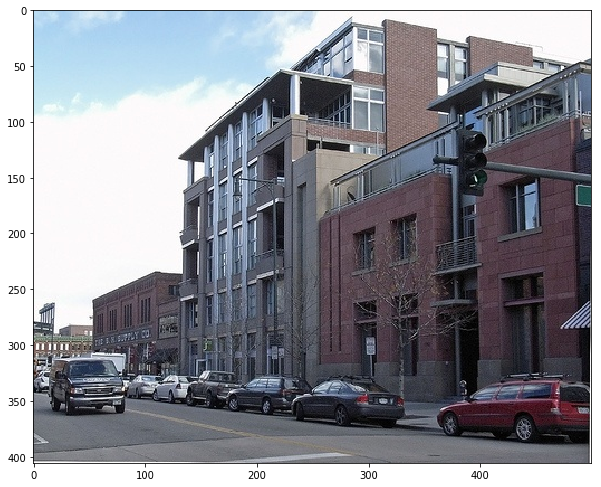

In [2]:
is_gpu = False
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    is_gpu = True
# for VOC
class_names = ['__background__',
               'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
               'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
num_classes = len(class_names)

# Construct networks based on VGG16.
cfg = voc320
base_network = 'vgg16'
model_path = '../output/vgg16_refinedet320_voc_120000.pth'
print('Construct {}_refinedet network.'.format(base_network))
refinedet = VGGRefineDet(cfg['num_classes'], cfg)
refinedet.create_architecture()
# For CPU
net = refinedet
# For GPU/GPUs
if is_gpu:
    net = refinedet.cuda()
    cudnn.benchmark = True
# Load weights
net.load_weights(model_path)
net.eval()
# read image
img_path = '000004.jpg'
image = cv2.imread(img_path, cv2.IMREAD_COLOR)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()


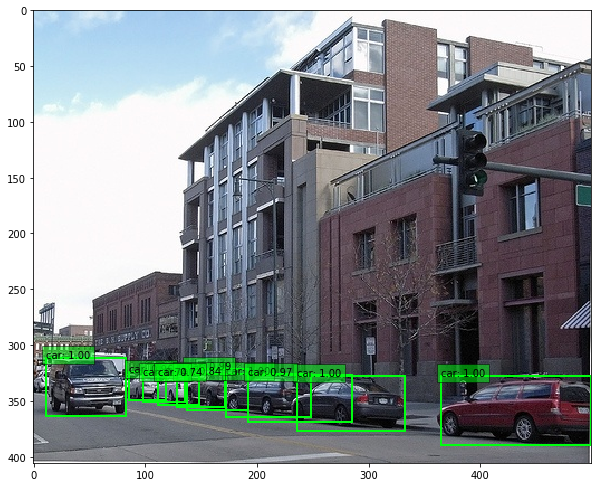

In [3]:
# preprocess
# norm_image = base_transform(image, (320, 320), MEANS)
norm_image = cv2.resize(image, (320, 320)).astype(np.float32)
norm_image -= MEANS
norm_image = norm_image.astype(np.float32)
norm_image = torch.from_numpy(norm_image).permute(2, 0, 1)

# forward
input_var = Variable(norm_image.unsqueeze(0))  # wrap tensor in Variable
if torch.cuda.is_available():
    input_var = input_var.cuda()
detection = net(input_var)

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, num_classes)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# scale each detection back up to the image,
# scale = (width, height, width, height)
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
threshold = 0.5
num_top = detection.size(2)

for i in range(1, num_classes):
    for j in range(num_top):
        score = detection[0, i, j, 0]
        if score < threshold:
            continue
        label_name = class_names[i]
        display_txt = '%s: %.2f' % (label_name, score)
        pt = (detection[0, i, j, 1:] * scale).cpu().numpy()
#         print(pt)
        coords = (pt[0], pt[1]), pt[2] - pt[0] + 1, \
                 pt[3] - pt[1] + 1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, 
            fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, 
            bbox={'facecolor':color, 'alpha':0.5})
        